# Изучение закономерностей, определяющих успешность игр.

## Обзор данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('games.csv')

In [3]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Согласно документации к данным:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организацииESRB (англ.Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Вывод.
- Название столбцов не приведено к нижнему регистру. 
- Столбцы year_of_release и user_score не в том типе.
- Пропуски в столбцах year_of_release, critic_score, user_score, name, genre и rating.

## Предобработка данных

In [5]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

Заменим название столбцов, приведем к нижнему регистру.

In [6]:
data.columns= data.columns.str.lower()

In [7]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Преобразуем данные в нужные типы:
- столбец year_of_release в целочисленный тип так как это год и он не может быть дробным;
- столбец user_score в вещественный, так как имеется дробная часть.

In [8]:
data['year_of_release'] = np.int16(data['year_of_release'])

In [9]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int16  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int16(1), object(4)
memory usage: 1.3+ MB


In [11]:
data.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Пропуски в столбцах critic_score и user_score пропуски скорее всего говорят о том, что оценки не проводились. В столбце user_score встречается аббревиатура 'tbd' (от 'To Be Determined') - означает, что рейтинг появится в скором времени. Подобные пропуски лучше не заполнять. Аббревиатуру 'tbd' привести к значению NaN, что было сделано выше. Пропуски в столбцах name, genre и rating заменим на строку 'unknown'.

In [12]:
columns_to_replace=['name', 'genre', 'rating']
for column in columns_to_replace:
    data[column] = data[column].fillna('unknown')

In [13]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating                0
dtype: int64

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [14]:
def sales(row):
    na_sales = row['na_sales']
    eu_sales = row['eu_sales']
    jp_sales = row['jp_sales']
    other_sales = row['other_sales']
    return na_sales+eu_sales+jp_sales+other_sales

In [15]:
data['sales'] = data.apply(sales, axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


В колонке year_of_release присутствует значение 0, которые обозначают пропуски.

In [16]:
data.query('year_of_release==0')['year_of_release'].count()/data['year_of_release'].count()*100

1.609332934489979

Так как процент данных с пропусками невелик (1.6%), то эти данные можно отбросить.

In [17]:
data = data.query('year_of_release!=0')
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


### Вывод.
- Название столбцов приведено к нижнему регистру. 
- столбец year_of_release преобразован в целочисленный тип, а столбец user_score в вещественный.
- Пропуски в столбцах critic_score и user_score пропуски скорее всего говорят о том, что оценки не проводились. В столбце user_score встречается аббревиатура 'tbd' (от 'To Be Determined') - означает, что рейтинг появится в скором времени. Подобные пропуски лучше не заполнять. Аббревиатуру 'tbd' привести к значению NaN, что было сделано выше. Пропуски в столбцах name, genre и rating заменим на строку 'unknown'.
- Посчитаны суммарные продажи во всех регионах и записаны в отдельный столбец.
- Отброшены данные со значением 0 в колонке year_of_release.

##  Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы.

In [18]:
data['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      62
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

До 1994 года выпуск игр мал.

In [19]:
data = data.query('year_of_release>=1994')
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80


Посмотрим, как менялись продажи по платформам.

In [20]:
data.groupby('platform')['sales'].sum().sort_values(ascending=False)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       252.66
XB       251.57
N64      218.01
GC       196.73
XOne     159.32
GB       152.08
SNES      84.67
WiiU      82.19
PSV       53.81
SAT       33.59
DC        15.95
GEN        8.13
WS         1.42
NG         1.23
SCD        0.36
TG16       0.16
NES        0.11
3DO        0.10
PCFX       0.03
Name: sales, dtype: float64

Возьмем первые 6 платформ с самыми большими объемами продаж и построим распределение по годам.

In [21]:
data_top_platform = data.query('(platform == "PS2")or(platform == "X360")or(platform == "PS3")or(platform == "Wii")or(platform == "DS")or(platform == "PS")')
data_top_platform.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


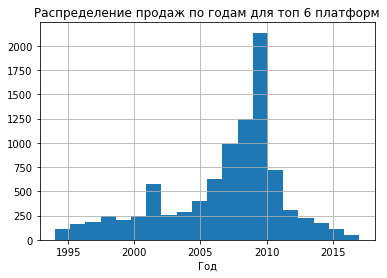

In [22]:
data_top_platform['year_of_release'].hist(bins=20, range=(1994, 2017))
plt.title('Распределение продаж по годам для топ 6 платформ')
plt.xlabel('Год')
plt.show()

Больше всего продаж было в 2001 и в 2005-2011 годах.

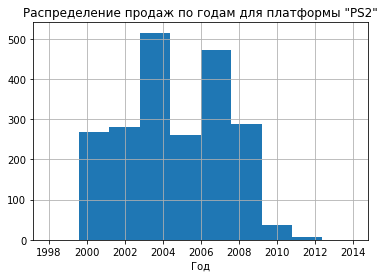

In [23]:
data_top_platform.query('platform == "PS2"')['year_of_release'].hist(range=(1998, 2014))
plt.title('Распределение продаж по годам для платформы "PS2"')
plt.xlabel('Год')
plt.show()

Платформа "PS2" существовала 12 лет (с 1999 по 2012 года), но в последние 3 года существования продажи на ней были очень малы. Максимальные продажи были в 2003 и 2006 годах.

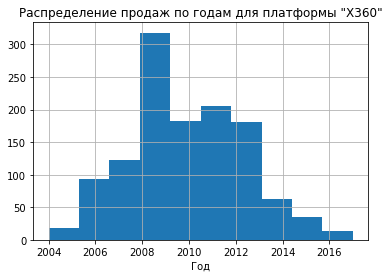

In [24]:
data_top_platform.query('platform == "X360"')['year_of_release'].hist(range=(2004, 2017))
plt.title('Распределение продаж по годам для платформы "X360"')
plt.xlabel('Год')
plt.show()

Платформа "X360" существовала 12 лет (с 2004 по 2017), но в первый и последние года существования продажи на ней были очень малы. Максимальные продажи были в 2008 году.

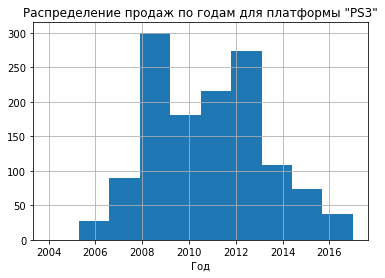

In [25]:
data_top_platform.query('platform == "PS3"')['year_of_release'].hist(range=(2004, 2017))
plt.title('Распределение продаж по годам для платформы "PS3"')
plt.xlabel('Год')
plt.show()

Платформа "PS3" существовала 11 лет (с 2005 по 2017), но в первый и последние года существования продажи на ней были очень малы. Вероятно, на ней будут небольшие продажи в 2017 году. Максимальные продажи были в 2008 и 2012 годах.

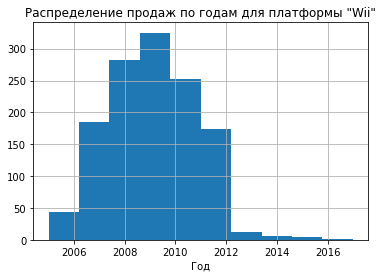

In [26]:
data_top_platform.query('platform == "Wii"')['year_of_release'].hist(range=(2005, 2017))
plt.title('Распределение продаж по годам для платформы "Wii"')
plt.xlabel('Год')
plt.show()

Платформа "Wii" существовала 11 лет (с 2005 по 2017). Основной объем продаж происходил с 2006 по 2012 года. Максимальные продажи были в 2009 году.

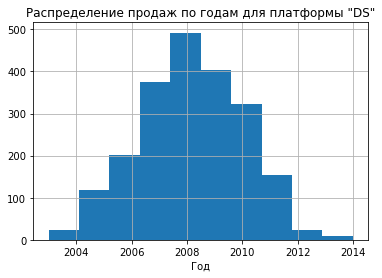

In [27]:
data_top_platform.query('platform == "DS"')['year_of_release'].hist(range=(2003, 2014))
plt.title('Распределение продаж по годам для платформы "DS"')
plt.xlabel('Год')
plt.show()

Платформа "DS" существовала 10 лет (с 2003 по 2014), но в первый и 2 последних годах существования продажи на ней были очень малы. Максимальные продажи были в 2008 году.

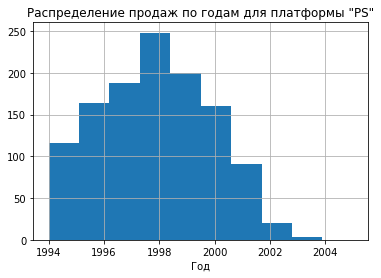

In [28]:
data_top_platform.query('platform == "PS"')['year_of_release'].hist(range=(1994, 2005))
plt.title('Распределение продаж по годам для платформы "PS"')
plt.xlabel('Год')
plt.show()

Платформа "DS" существовала 9 лет (с 1994 по 2004), но в 2 последних годах существования продажи на ней были очень малы. Максимальные продажи были в 1998 году.

В среднем платформа существует 11 лет.

Определим актуальный для того чтобы выбрать данные, которые помогут построить прогноз на 2017 год.

Построим график распределения продаж по годам для всех платформ.

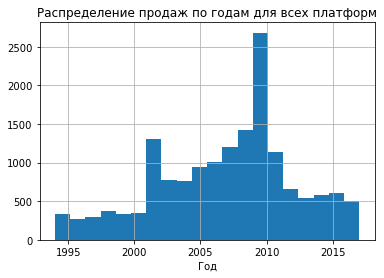

In [29]:
data['year_of_release'].hist(bins=20, range=(1994, 2017))
plt.title('Распределение продаж по годам для всех платформ')
plt.xlabel('Год')
plt.show()

Судя по графикам "Распределение продаж по годам для всех платформ" и графикам распределения продаж по годам для каждой платформы, входящей в топ 6, можно выделить актуальный период с 2014 по 2016 года.

In [30]:
data_actual = data.query('year_of_release>=2014')
data_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98


Выберем несколько потенциально прибыльных платформ в актуальном периоде.

In [31]:
data_actual.groupby('platform')['sales'].sum().sort_values(ascending=False)

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: sales, dtype: float64

В топ 5 потенциально прибыльных платформ в актуальном периоде входят "PS4", "PS3", "XOne", "3DS", "X360".

In [32]:
data_actual_top_platform = data_actual.query('(platform == "PS4")or(platform == "X360")or(platform == "PS3")or(platform == "XOne")or(platform == "3DS")')
data_actual_top_platform.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98


Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

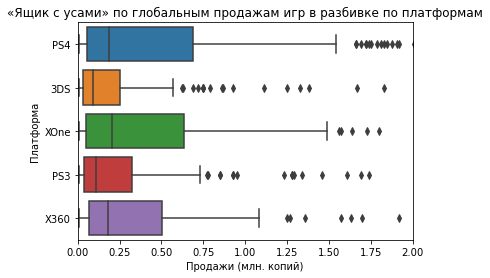

In [33]:
fig, ax = plt.subplots()
sns.boxplot( x=data_actual_top_platform['sales'], y=data_actual_top_platform['platform'], ax = ax )
ax.set_xlim( 0, 2)
plt.title('«Ящик с усами» по глобальным продажам игр в разбивке по платформам')
plt.xlabel('Продажи (млн. копий)')
plt.ylabel('Платформа')
plt.show()

Нижний «ус» близок к 0 у всех платформ, минимальное значение. Для платформ "PS4", "XOne", "3DS", "PS3", "X360" верхний «ус» заканчивается около 1.6, 1.5, 0.6, 0.7, 1.1 млн. копий соответственно — это 1,5 межквартильного размаха, добавленного к 3-му квартилю. Это ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом. Более высокие значения рисуются отдельными точками.

Посмотрим, как влияют на продажи внутри одной популярной платформы ("PS4") отзывы пользователей и критиков.

Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

In [34]:
data_actual_PS4 = data_actual.loc[data_actual['platform'] == 'PS4']

In [35]:
data_actual_PS4_critic_score = data_actual_PS4.loc[:,['sales', 'critic_score']] 
data_actual_PS4_critic_score.dropna(axis=0,inplace=True)

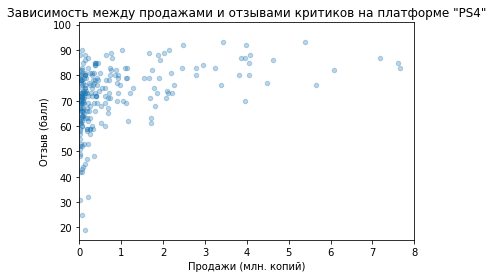

In [36]:
fig, ax = plt.subplots()
data_actual_PS4_critic_score.plot(x='sales', y='critic_score', kind='scatter', alpha=0.3, ax = ax) 
ax.set_xlim( 0, 8)
plt.title('Зависимость между продажами и отзывами критиков на платформе "PS4"')
plt.xlabel('Продажи (млн. копий)')
plt.ylabel('Отзыв (балл)')
plt.show()

In [37]:
data_actual_PS4_critic_score['sales'].corr(data_actual_PS4_critic_score['critic_score'])

0.4026614106810408

Корреляция в 0.40 говорит о наличии слабой связи. Выходит, что на платформе "PS4" зависимость продаж от отзыв критиков практически отсутствует.

In [38]:
data_actual_PS4_user_score = data_actual_PS4.loc[:,['sales', 'user_score']] 
data_actual_PS4_user_score.dropna(axis=0,inplace=True)

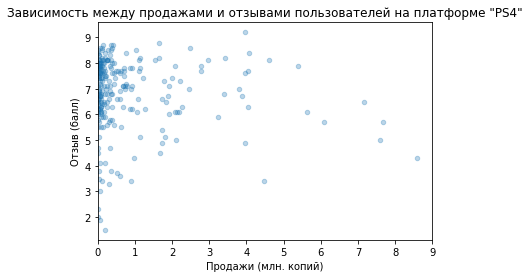

In [39]:
fig, ax = plt.subplots()
data_actual_PS4_user_score.plot(x='sales', y='user_score', kind='scatter', alpha=0.3, ax = ax) 
ax.set_xlim( 0, 9)
plt.title('Зависимость между продажами и отзывами пользователей на платформе "PS4"')
plt.xlabel('Продажи (млн. копий)')
plt.ylabel('Отзыв (балл)')
plt.show()

In [40]:
data_actual_PS4_user_score['sales'].corr(data_actual_PS4_user_score['user_score'])

-0.040131589472697335

Корреляция -0.04 очень близка к 0, что говорит об отсутствии связи между отзывами пользователей и продажами на платформе "PS4".

Посмотрим, как влияют на продажи внутри одной популярной платформы ("XOne") отзывы пользователей и критиков.

Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

In [41]:
data_actual_XOne = data_actual.loc[data_actual['platform'] == 'XOne']

In [42]:
data_actual_XOne_critic_score = data_actual_XOne.loc[:,['sales', 'critic_score']] 
data_actual_XOne_critic_score.dropna(axis=0,inplace=True)

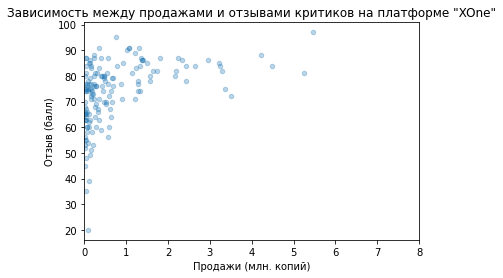

In [43]:
fig, ax = plt.subplots()
data_actual_XOne_critic_score.plot(x='sales', y='critic_score', kind='scatter', alpha=0.3, ax = ax) 
ax.set_xlim( 0, 8)
plt.title('Зависимость между продажами и отзывами критиков на платформе "XOne"')
plt.xlabel('Продажи (млн. копий)')
plt.ylabel('Отзыв (балл)')
plt.show()

In [44]:
data_actual_XOne_critic_score['sales'].corr(data_actual_XOne_critic_score['critic_score'])

0.4286769437033319

Корреляция в 0.43 говорит о наличии слабой связи. Выходит, что на платформе "XOne" зависимость продаж от отзыв критиков практически отсутствует.

In [45]:
data_actual_XOne_user_score = data_actual_XOne.loc[:,['sales', 'user_score']] 
data_actual_XOne_user_score.dropna(axis=0,inplace=True)

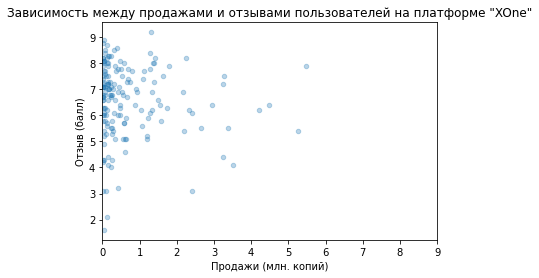

In [46]:
fig, ax = plt.subplots()
data_actual_XOne_user_score.plot(x='sales', y='user_score', kind='scatter', alpha=0.3, ax = ax) 
ax.set_xlim( 0, 9)
plt.title('Зависимость между продажами и отзывами пользователей на платформе "XOne"')
plt.xlabel('Продажи (млн. копий)')
plt.ylabel('Отзыв (балл)')
plt.show()

In [47]:
data_actual_XOne_user_score['sales'].corr(data_actual_XOne_user_score['user_score'])

-0.07038392806475818

Корреляция -0.07 очень близка к 0, что говорит об отсутствии связи между отзывами пользователей и продажами на платформе "PS4".

Посмотрим, как влияют на продажи на всех платформах отзывы пользователей и критиков.

Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

In [48]:
data_actual_critic_score = data.loc[:,['sales', 'critic_score']] 
data_actual_critic_score.dropna(axis=0,inplace=True)

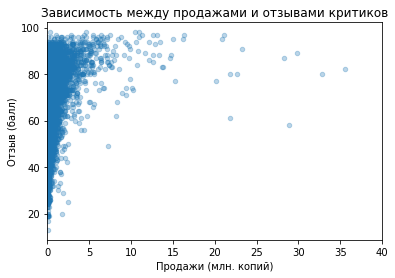

In [49]:
fig, ax = plt.subplots()
data_actual_critic_score.plot(x='sales', y='critic_score', kind='scatter', alpha=0.3, ax = ax) 
ax.set_xlim( 0, 40)
plt.title('Зависимость между продажами и отзывами критиков')
plt.xlabel('Продажи (млн. копий)')
plt.ylabel('Отзыв (балл)')
plt.show()

In [50]:
data_actual_critic_score['sales'].corr(data_actual_critic_score['critic_score'])

0.24538971391504122

Корреляция в 0.25 говорит что связи между отзывами критиков и продажами практически нет.

In [51]:
data_actual_user_score = data.loc[:,['sales', 'user_score']] 
data_actual_user_score.dropna(axis=0,inplace=True)

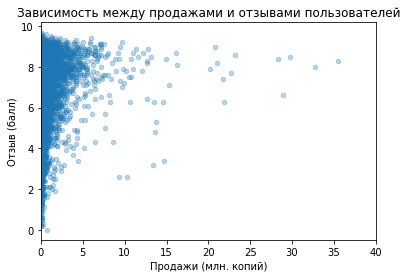

In [52]:
fig, ax = plt.subplots()
data_actual_user_score.plot(x='sales', y='user_score', kind='scatter', alpha=0.3, ax = ax) 
ax.set_xlim( 0, 40)
plt.title('Зависимость между продажами и отзывами пользователей')
plt.xlabel('Продажи (млн. копий)')
plt.ylabel('Отзыв (балл)')
plt.show()

In [53]:
data_actual_user_score['sales'].corr(data_actual_user_score['user_score'])

0.0878840638404564

Корреляция 0.09 очень близка к 0, что говорит об отсутствии связи между отзывами пользователей и продажами.

Рассмотрим медианные продажи в каждом жанре.

In [54]:
data_actual.groupby('genre')['sales'].median().sort_values(ascending=False)

genre
Shooter         0.515
Sports          0.180
Platform        0.140
Fighting        0.125
Role-Playing    0.110
Simulation      0.100
Action          0.090
Misc            0.090
Racing          0.090
Strategy        0.060
Puzzle          0.045
Adventure       0.030
Name: sales, dtype: float64

Больше всего медианных продаж с играми в жанре Shooter (0.515), меньше - Adventure (0.030). К жанрам с высокими медианными продажами относятся: Shooter, Sports, Platforms и Fighting. К жанрам с низкими продажами относятся: Puzzle и Adventure.

###  Выводы.
- Рассматриваются данные с 1994 года, однако за актуальный период был принят период с 2014 по 2016 года.
- Платформами с самым большим количеством продаж за общий период: "PS2" (1233.56 млн.копий), "X360" (961.24 млн.копий), "PS3" (931.34 млн.копий), "Wii" (891.18 млн.копий), "DS"  (802.76 млн.копий), "PS" (727.58 млн.копий).
- Платформа "PS2" существовала 12 лет (с 1999 по 2012 года), но в последние 3 года существования продажи на ней были очень малы. Максимальные продажи были в 2003 и 2006 годах. Платформа "X360" существовала 12 лет (с 2004 по 2017), но в первый и последний года существования продажи на ней были очень малы. Максимальные продажи были в 2008 году. Платформа "PS3" существовала 11 лет (с 2005 по 2017), но в первый и последний года существования продажи на ней были очень малы. Вероятно, на ней будут небольшие продажи в 2017 году. Максимальные продажи были в 2008 и 2012 годах. Платформа "Wii" существовала 11 лет (с 2005 по 2017). Основной объем продаж происходил с 2006 по 2012 года. Максимальные продажи были в 2009 году. Платформа "DS" существовала 10 лет (с 2003 по 2014), но в первый и 2 последних годах существования продажи на ней были очень малы. Максимальные продажи были в 2008 году. Платформа "DS" существовала 9 лет (с 1994 по 2004), но в 2 последних годах существования продажи на ней были очень малы. Максимальные продажи были в 1998 году.
- В среднем платформа существует 11 лет.
- В топ 5 потенциально прибыльных платформ в актуальном периоде входят "PS4" (288.15 млн.копий), "XOne" (140.36 млн.копий), "3DS" (86.68 млн.копий), "PS3" (68.18 млн.копий), "X360" (48.22 млн.копий).
- Граница нормального размаха для платформ "PS4", "XOne", "3DS", "PS3", "X360" от 0 до 1.6, 1.5, 0.6, 0.7, 1.1 млн. копий соответственно. Всё, что лежит за ней, считается выбросом. 
- Внутри одной популярной платформы ("PS4") зависимость продаж от отзыв критиков практически отсутствует (корреляция 0.40), а связь между отзывами пользователей и продажами отсутствует полностью (корреляция -0.04).
- Внутри одной популярной платформы ("XOne") зависимость продаж от отзыв критиков практически отсутствует (корреляция 0.43), а связь между отзывами пользователей и продажами отсутствует полностью (корреляция -0.07).
- На всех платформах связь между отзывами критиков и продажами практически отсутствует (корреляция 0.25), связь между отзывами пользователей и продажами отсутствует (корреляция 0.09).
- Больше всего медианных продаж с играми в жанре Shooter (0.515), меньше - Adventure (0.030). К жанрам с высокими медианными продажами относятся: Shooter, Sports, Platforms и Fighting. К жанрам с низкими продажами относятся: Puzzle и Adventure.

##  Составление портрета пользователя каждого региона.

Определим самые популярные платформы (топ-5) для пользователя каждого региона (NA, EU, JP).

In [55]:
data_actual_na = data_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)

In [56]:
data_actual_na['percent'] = data_actual_na['na_sales']/sum(data_actual['na_sales'])*100
print(data_actual_na)

          na_sales    percent
platform                     
PS4          98.61  34.714497
XOne         81.27  28.610153
X360         28.30   9.962684
3DS          22.64   7.970147
PS3          22.05   7.762445
WiiU         19.36   6.815462
PC            7.23   2.545237
PSV           2.52   0.887137
Wii           2.08   0.732240
PSP           0.00   0.000000


In [57]:
data_actual_eu = data_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)

In [58]:
data_actual_eu['percent'] = data_actual_eu['eu_sales']/sum(data_actual['eu_sales'])*100
print(data_actual_eu)

          eu_sales    percent
platform                     
PS4         130.04  48.041968
XOne         46.25  17.086597
PS3          25.54   9.435496
PC           17.97   6.638836
3DS          16.12   5.955372
X360         15.49   5.722625
WiiU         13.15   4.858135
PSV           3.53   1.304123
Wii           2.59   0.956849
PSP           0.00   0.000000


In [59]:
data_actual_jp = data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)

In [60]:
data_actual_jp['percent'] = data_actual_jp['jp_sales']/sum(data_actual['jp_sales'])*100
print(data_actual_jp)

          jp_sales    percent
platform                     
3DS          44.24  47.523902
PS4          15.02  16.134923
PSV          14.54  15.619293
PS3          11.22  12.052852
WiiU          7.31   7.852616
PSP           0.36   0.386723
XOne          0.32   0.343753
X360          0.08   0.085938
PC            0.00   0.000000
Wii           0.00   0.000000


Топ-5 платформ в Северной Америке составляют "PS4" (98.61 млн.копий, что соответствует 34.71% от продаж в регионе), "XOne" (81.27 млн.копий, что соответствует 28.61% от продаж в регионе), "X360" (28.30 млн.копий, что соответствует 9.96% от продаж в регионе), "3DS" (22.64 млн.копий, что соответствует 7.97% от продаж в регионе), "PS3" (22.05 млн.копий, что соответствует 7.76% от продаж в регионе). Топ-5 платформ в Европе составляют "PS4" (130.04 млн.копий, что соответствует 48.04% от продаж в регионе), "XOne" (46.25 млн.копий, что соответствует 17.09% от продаж в регионе), "PS3" (25.54 млн.копий, что соответствует 9.44% от продаж в регионе), "PC" (17.97 млн.копий, что соответствует 6.64% от продаж в регионе), "3DS" (16.12 млн.копий, что соответствует 5.96% от продаж в регионе). Топ-5 платформ в Японии составляют "3DS" (44.2 млн.копий, что соответствует 47.52% от продаж в регионе), "PS4" (15.02 млн.копий, что соответствует 16.13% от продаж в регионе), "PSV" (14.54 млн.копий, что соответствует 15.62% от продаж в регионе), "PS3" (11.22 млн.копий, что соответствует 12.05% от продаж в регионе), "WiiU" (7.31 млн.копий, что соответствует 7.85% от продаж в регионе).

Определим самые популярные жанры (топ-5) для пользователя каждого региона (NA, EU, JP).

In [61]:
data_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False)

genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Fighting        12.43
Racing           8.74
Platform         6.79
Adventure        5.64
Simulation       2.63
Strategy         0.98
Puzzle           0.65
Name: na_sales, dtype: float64

In [62]:
data_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)

genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Misc            12.86
Simulation       7.30
Platform         6.80
Fighting         6.69
Adventure        6.49
Strategy         1.79
Puzzle           0.52
Name: eu_sales, dtype: float64

In [63]:
data_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)

genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Adventure        3.60
Sports           3.26
Platform         2.69
Simulation       2.31
Racing           1.76
Strategy         0.95
Puzzle           0.93
Name: jp_sales, dtype: float64

Топ-5 жанров в Северной Америке составляют Shooter (79.02 млн.копий), Action (72.53 млн.копий), Sports (46.13 млн.копий), Role-Playing (33.47 млн.копий), Misc (15.05 млн.копий). Топ-5 жанров в Европе составляют Action (74.68 млн.копий), Shooter (65.52 млн.копий), Sports (45.73 млн.копий), Role-Playing (28.17 млн.копий), Racing (14.13 млн.копий). Топ-5 жанров в Японии составляют Role-Playing (31.16 млн.копий), Action (29.58 млн.копий), Fighting (6.37 млн.копий), Misc (5.61 млн.копий), Shooter (4.87 млн.копий). Во всех регионах популярными жанрами являются Action, Shooter, Role-Playing. 

Выясним, влияет ли рейтинг ESRB на продажи в отдельном регионе.

Рассмотрим влияние рейтинга ESRB на продажи в Северной Америке.

In [64]:
data_actual.groupby('rating')['na_sales'].sum().sort_values(ascending=False)

rating
M          96.42
unknown    64.72
E          50.74
T          38.95
E10+       33.23
Name: na_sales, dtype: float64

В топ-5 попадают игры с пометкой "M" (От 17 лет), с пометкой "неизвестен", "E" (Для всех), "T" (Подросткам 13—19 лет),"E10+" (Для всех старше 10 лет).

Рассмотрим влияние рейтинга ESRB на продажи в Европе.

In [65]:
data_actual.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)

rating
M          93.44
unknown    58.95
E          58.06
T          34.07
E10+       26.16
Name: eu_sales, dtype: float64

В топ-5 попадают игры с пометкой "M" (От 17 лет), с пометкой "неизвестен", "E" (Для всех), "T" (Подросткам 13—19 лет),"E10+" (Для всех старше 10 лет).

Рассмотрим влияние рейтинга ESRB на продажи в Японии.

In [66]:
data_actual.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)

rating
unknown    56.90
T          14.78
E           8.94
M           8.01
E10+        4.46
Name: jp_sales, dtype: float64

В топ-5 попадают игры с пометкой "неизвестен", "T" (Подросткам 13—19 лет), "E" (Для всех), "M" (От 17 лет), "E10+" (Для всех старше 10 лет).

###  Вывод.
- Топ-5 платформ в Северной Америке составляют "PS4" (98.61 млн.копий, что соответствует 34.71% от продаж в регионе), "XOne" (81.27 млн.копий, что соответствует 28.61% от продаж в регионе), "X360" (28.30 млн.копий, что соответствует 9.96% от продаж в регионе), "3DS" (22.64 млн.копий, что соответствует 7.97% от продаж в регионе), "PS3" (22.05 млн.копий, что соответствует 7.76% от продаж в регионе). Топ-5 платформ в Европе составляют "PS4" (130.04 млн.копий, что соответствует 48.04% от продаж в регионе), "XOne" (46.25 млн.копий, что соответствует 17.09% от продаж в регионе), "PS3" (25.54 млн.копий, что соответствует 9.44% от продаж в регионе), "PC" (17.97 млн.копий, что соответствует 6.64% от продаж в регионе), "3DS" (16.12 млн.копий, что соответствует 5.96% от продаж в регионе). Топ-5 платформ в Японии составляют "3DS" (44.2 млн.копий, что соответствует 47.52% от продаж в регионе), "PS4" (15.02 млн.копий, что соответствует 16.13% от продаж в регионе), "PSV" (14.54 млн.копий, что соответствует 15.62% от продаж в регионе), "PS3" (11.22 млн.копий, что соответствует 12.05% от продаж в регионе), "WiiU" (7.31 млн.копий, что соответствует 7.85% от продаж в регионе).
- Топ-5 жанров в Северной Америке составляют Shooter (79.02 млн.копий), Action (72.53 млн.копий), Sports (46.13 млн.копий), Role-Playing (33.47 млн.копий), Misc (15.05 млн.копий). Топ-5 жанров в Европе составляют Action (74.68 млн.копий), Shooter (65.52 млн.копий), Sports (45.73 млн.копий), Role-Playing (28.17 млн.копий), Racing (14.13 млн.копий). Топ-5 жанров в Японии составляют Role-Playing (31.16 млн.копий), Action (29.58 млн.копий), Fighting (6.37 млн.копий), Misc (5.61 млн.копий), Shooter (4.87 млн.копий). Во всех регионах популярными жанрами являются Action, Shooter, Role-Playing.
- В Северной Америке в топ-5 по рейтингу ESRB попадают игры с пометкой "M" (От 17 лет), с пометкой "неизвестен", "E" (Для всех), "T" (Подросткам 13—19 лет),"E10+" (Для всех старше 10 лет). В Европе в топ-5 попадают игры с пометкой "M" (От 17 лет), с пометкой "неизвестен", "E" (Для всех), "T" (Подросткам 13—19 лет),"E10+" (Для всех старше 10 лет). В Японии в топ-5 попадают игры с пометкой "неизвестен", "T" (Подросткам 13—19 лет), "E" (Для всех), "M" (От 17 лет), "E10+" (Для всех старше 10 лет).

##  Проверка гипотезы.

За средний пользовательский рейтинг будем принимать оценки пользователей.

### Проверка гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

In [67]:
data_actual_xbox_one = data_actual.query('platform == "XOne"').dropna()

In [68]:
data_actual_pc = data_actual.query('platform == "PC"').dropna()

Проверим гипотезу о равенстве средних двух генеральных совокупностей с помощью t-теста. Однако укажем, что дисперсии не равны, так как выборки разного размера.
- H₀: средние пользовательские рейтинги платформ Xbox One и PC одинаковы
- H₁: средние пользовательские рейтинги платформ Xbox One и PC различаются

In [69]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    data_actual_xbox_one['user_score'], 
    data_actual_pc['user_score'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.1403785186826978
Не получилось отвергнуть нулевую гипотезу


p-value больше критического уровня статистической значимости (0.14 больше 0.05). Нельзя опровергнуть нулевую гипотезу в пользу альтернативной.

### Проверка гипотезы: средние пользовательские рейтинги жанров Action и Sports разные.

In [70]:
data_actual_actione = data_actual.query('genre == "Action"').dropna()

In [71]:
data_actual_sports = data_actual.query('genre == "Sports"').dropna()

Проверим гипотезу о равенстве средних двух генеральных совокупностей с помощью t-теста.
- H₀: средние пользовательские рейтинги жанров Action и Sports одинаковы
- H₁: средние пользовательские рейтинги жанров Action и Sports разные

In [72]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    data_actual_actione['user_score'], 
    data_actual_sports['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.0540895999943536e-10
Отвергаем нулевую гипотезу


p-value меньше критического уровня статистической значимости (4.05e-10 меньше 0.05). Отвергаем нулевую гипотезу в пользу альтернативной - средние пользовательские рейтинги жанров Action и Sports разные.

###  Вывод.
- гипотеза, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые не опровергнута.
- гипотеза, что средние пользовательские рейтинги жанров Action и Sports разные не опровергнута.

##  Вывод.

1.  Проведе исследовательский анализ данных: 
- Изучено сколько игр выпускалось в разные годы, отброшенны данные до 1994, так как в этот вериод игор очень мало.
- Изучено как менялись продажи по платформам. Платформами с самым большим количеством продаж за общий период: "PS2" (1233.56 млн.копий), "X360" (961.24 млн.копий), "PS3" (931.34 млн.копий), "Wii" (891.18 млн.копий), "DS" (802.76 млн.копий), "PS" (727.58 млн.копий).
- Платформа "PS2" существовала 12 лет (с 1999 по 2012 года), но в последние 3 года существования продажи на ней были очень малы. Максимальные продажи были в 2003 и 2006 годах. Платформа "X360" существовала 12 лет (с 2004 по 2017), но в первый и последний года существования продажи на ней были очень малы. Максимальные продажи были в 2008 году. Платформа "PS3" существовала 11 лет (с 2005 по 2017), но в первый и последний года существования продажи на ней были очень малы. Вероятно, на ней будут небольшие продажи в 2017 году. Максимальные продажи были в 2008 и 2012 годах. Платформа "Wii" существовала 11 лет (с 2005 по 2017). Основной объем продаж происходил с 2006 по 2012 года. Максимальные продажи были в 2009 году. Платформа "DS" существовала 10 лет (с 2003 по 2014), но в первый и 2 последних годах существования продажи на ней были очень малы. Максимальные продажи были в 2008 году. Платформа "DS" существовала 9 лет (с 1994 по 2004), но в 2 последних годах существования продажи на ней были очень малы. Максимальные продажи были в 1998 году.
- В среднем платформа существует 11 лет.
- За актуальный период принят период с 2014 по 2016 года.
- В топ 5 потенциально прибыльных платформ в актуальном периоде входят "PS4" (288.15 млн.копий), "XOne" (140.36 млн.копий), "3DS" (86.68 млн.копий), "PS3" (68.18 млн.копий), "X360" (48.22 млн.копий).
- Граница нормального размаха для платформ "PS4", "XOne", "3DS", "PS3", "X360" от 0 до 1.6, 1.5, 0.6, 0.7, 1.1 млн. копий соответственно. Всё, что лежит за ней, считается выбросом.
- Внутри одной популярной платформы ("PS4") зависимость продаж от отзыв критиков практически отсутствует (корреляция 0.40), а связь между отзывами пользователей и продажами отсутствует полностью (корреляция -0.04).
- На всех платформах связь между отзывами критиков и продажами практически отсутствует (корреляция 0.25), связь между отзывами пользователей и продажами отсутствует (корреляция 0.09). Внутри одной популярной платформы ("XOne") зависимость продаж от отзыв критиков практически отсутствует (корреляция 0.43), а связь между отзывами пользователей и продажами отсутствует полностью (корреляция -0.07).
- Больше всего медианных продаж с играми в жанре Shooter (0.515), меньше - Adventure (0.030). К жанрам с высокими медианными продажами относятся: Shooter, Sports, Platforms и Fighting. К жанрам с низкими продажами относятся: Puzzle и Adventure.
2. Составлен портрет пользователя каждого региона.
- Топ-5 платформ в Северной Америке составляют "PS4" (98.61 млн.копий, что соответствует 34.71% от продаж в регионе), "XOne" (81.27 млн.копий, что соответствует 28.61% от продаж в регионе), "X360" (28.30 млн.копий, что соответствует 9.96% от продаж в регионе), "3DS" (22.64 млн.копий, что соответствует 7.97% от продаж в регионе), "PS3" (22.05 млн.копий, что соответствует 7.76% от продаж в регионе). Топ-5 платформ в Европе составляют "PS4" (130.04 млн.копий, что соответствует 48.04% от продаж в регионе), "XOne" (46.25 млн.копий, что соответствует 17.09% от продаж в регионе), "PS3" (25.54 млн.копий, что соответствует 9.44% от продаж в регионе), "PC" (17.97 млн.копий, что соответствует 6.64% от продаж в регионе), "3DS" (16.12 млн.копий, что соответствует 5.96% от продаж в регионе). Топ-5 платформ в Японии составляют "3DS" (44.2 млн.копий, что соответствует 47.52% от продаж в регионе), "PS4" (15.02 млн.копий, что соответствует 16.13% от продаж в регионе), "PSV" (14.54 млн.копий, что соответствует 15.62% от продаж в регионе), "PS3" (11.22 млн.копий, что соответствует 12.05% от продаж в регионе), "WiiU" (7.31 млн.копий, что соответствует 7.85% от продаж в регионе).
- Топ-5 жанров в Северной Америке составляют Shooter (79.02 млн.копий), Action (72.53 млн.копий), Sports (46.13 млн.копий), Role-Playing (33.47 млн.копий), Misc (15.05 млн.копий). Топ-5 жанров в Европе составляют Action (74.68 млн.копий), Shooter (65.52 млн.копий), Sports (45.73 млн.копий), Role-Playing (28.17 млн.копий), Racing (14.13 млн.копий). Топ-5 жанров в Японии составляют Role-Playing (31.16 млн.копий), Action (29.58 млн.копий), Fighting (6.37 млн.копий), Misc (5.61 млн.копий), Shooter (4.87 млн.копий). Во всех регионах популярными жанрами являются Action, Shooter, Role-Playing.
- В Северной Америке в топ-5 по рейтингу ESRB попадают игры с пометкой "M" (От 17 лет), с пометкой "неизвестен", "E" (Для всех), "T" (Подросткам 13—19 лет),"E10+" (Для всех старше 10 лет). В Европе в топ-5 попадают игры с пометкой "M" (От 17 лет), с пометкой "неизвестен", "E" (Для всех), "T" (Подросткам 13—19 лет),"E10+" (Для всех старше 10 лет). В Японии в топ-5 попадают игры с пометкой "неизвестен", "T" (Подросткам 13—19 лет), "E" (Для всех), "M" (От 17 лет), "E10+" (Для всех старше 10 лет).
3. Проверены гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые; средние пользовательские рейтинги жанров Action и Sports разные.
- гипотеза, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые не опровергнута.
- гипотеза, что средние пользовательские рейтинги жанров Action и Sports разные не опровергнута.
